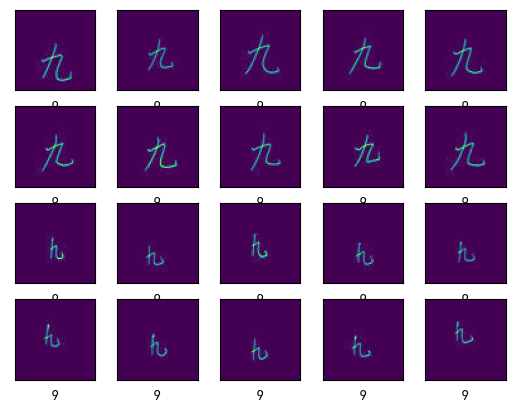

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os,PIL,pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras

warnings.filterwarnings("ignore")#忽略警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


# -*- coding: utf-8 -*-

train = pd.read_csv("C:/Users/Latticeshop/Documents/chineseMnist/chinese_mnist.csv")
# int编码集
hanzi_map = {'零':0, '一':1, '二':2, '三':3, '四':4, '五':5, '六':6, '七':7, '八':8, '九':9, '十':10, '百':11, '千':12, '万':13, '亿':14}

#训练数据的标签
train_image_label = [hanzi_map[i] for i in train["character"]]

# print(train_image_label)

#将标签切片
train_label_ds = tf.data.Dataset.from_tensor_slices(train_image_label)

#训练数据的具体路径
img_dir = "C:/Users/Latticeshop/Documents/chineseMnist/Chinese MNIST_data_datasets/"
train_image_paths = []
for row in train.itertuples():
    suite_id = row[1]
    sample_id = row[2]
    code = row[3]
    train_image_paths.append(img_dir+"input_"+str(suite_id)+"_"+str(sample_id)+"_"+str(code)+".jpg")

#对图片路径进行切片
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)

# train_image_paths:  'C:/Users/Latticeshop/Documents/chineseMnist/Chinese MNIST_data_datasets/_16_2_10.jpg', 'C:/Users/Latticeshop/Documents/chineseMnist/Chinese MNIST_data_datasets/_16_3_10.jpg'

#超参数
height = 64
width = 64
batch_size = 128
epochs = 15
lr=0.3

#图片预处理
def preprocess_image(image):
    image = tf.image.decode_jpeg(image,channels = 3)
    image = tf.image.resize(image,[height,width])
    return image / 255.0
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

# def load_and_preprocess_image(path):
#     image = tf.io.read_file(path)
#     image = tf.image.decode_jpeg(image, channels=1) #单通道灰色
#     image = tf.image.resize(image, [height, width])
#     return image / 255.0


"""
将 train_path_ds 中的每个图像路径应用 load_and_preprocess_image 函数进行预处理,并将处理后的图像 Tensor 组成新的数据集 train_image_ds。
num_parallel_calls=tf.data.experimental.AUTOTUNE：这个参数告诉 TensorFlow 使用自动调整的并行数量来执行预处理操作,从而提高数据加载和预处理的效率。
tf.data.experimental.AUTOTUNE 会根据可用的系统资源自动调整并行度,以获得最佳性能。
"""
#根据路径读取图片并进行预处理
train_image_ds = train_path_ds.map(load_and_preprocess_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)

#将train_image_ds与train_label_ds组合在一起          
image_label_ds = tf.data.Dataset.zip((train_image_ds,train_label_ds))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # 显示图片
    images = plt.imread(train_image_paths[i])
    plt.imshow(images)
    # 显示标签
    plt.xlabel(train_image_label[i])
plt.show()


# 原数据中一共15000张图片，分为15类，每类1000张，并按照顺序排列，因此需要对数据进行打乱。
image_label_ds = image_label_ds.shuffle(15000)
# 按照8：2的比例划分训练集与测试集 对训练集中的前 2000 个样本进行随机打乱。 skip(12000)跳过
train_ds = image_label_ds.take(12000).shuffle(2000)
test_ds = image_label_ds.skip(12000).shuffle(3000)

# 对训练集与测试集进行batch_size 划分
"""
batch() 操作,将训练数据集转换成一个个小批量(batch)的形式,这样可以提高训练效率和内存利用率。
prefetch() 操作可以让 TensorFlow 在训练过程中异步地准备下一个批次的数据,减少数据加载对训练速度的影响。
"""
train_ds = train_ds.batch(batch_size)#设置batch_size
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


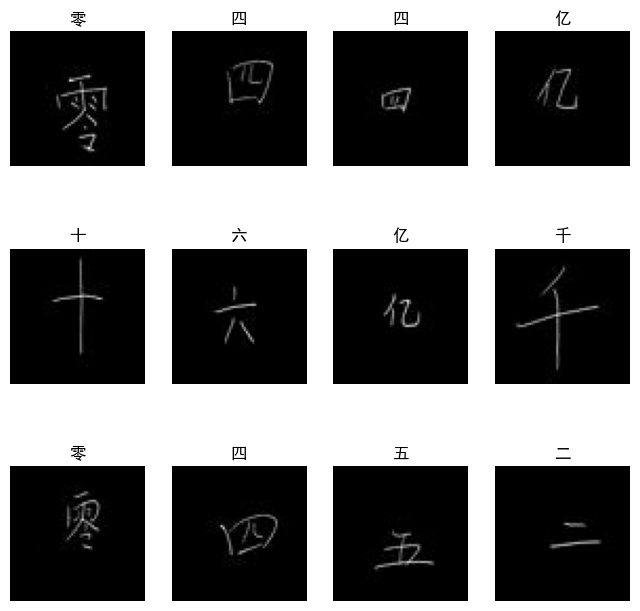

In [6]:
# 再次检查图片，看看是否被打乱顺序：
hanzi = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十', '百', '千', '万', '亿']
plt.figure(figsize=(8, 8))

#从 train_ds 数据集中取出前 1 个 batch 的数据。
for images, labels in train_ds.take(1):
#     print(images.shape)   
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(hanzi[labels[i].numpy()])  # 使用.numpy()将张量转换为 NumPy 数组

        plt.axis("off")
    break
plt.show()



In [8]:
# 构建模型

model = tf.keras.Sequential([
    #保持输出特征图大小与输入特征图大小相同。
    # 层数过低导致越训练精度下降无法拟合特征
    # 层数过高导致过拟合 loss飙升和test精度拟合卡在0.667  input_shape=(64, 64, 1)
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",input_shape=[64, 64, 3]),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(15, activation="softmax")
])

# 默认学习率 0.001。Adam 优化器会在训练过程中自动调整学习率,无需手动设置。
# 'categorical_crossentropy' 要求标签数据是独热编码格式(one-hot encoding)。 'sparse_categorical_crossentropy' 可以直接使用整数类别标签,不需要经过独热编码。
#     optimizer="adam",  optimizer=Adam(learning_rate=lr),
model.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs = epochs
)


# 评估模型
loss, accuracy = model.evaluate(test_ds)

print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,122,575 (4.28 MB)

 Trainable params: 1,122,575 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 438ms/step - accuracy: 0.2147 - loss: 2.3680 - val_accuracy: 0.7863 - val_loss: 0.7523
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 432ms/step - accuracy: 0.6651 - loss: 1.0037 - val_accuracy: 0.9110 - val_loss: 0.2899
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 52s 478ms/step - accuracy: 0.8125 - loss: 0.5481 - val_accuracy: 0.9497 - val_loss: 0.1659
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 425ms/step - accuracy: 0.8695 - loss: 0.3972 - val_accuracy: 0.9717 - val_loss: 0.0943
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 412ms/step - accuracy: 0.9207 - loss: 0.2566 - val_accuracy: 0.9813 - val_loss: 0.0795
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 321ms/step - accuracy: 0.9319 - loss: 0.2137 - val_accuracy: 0.9827 - val_loss: 0.0552
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - accuracy: 0.9475 - loss: 0.1734 - val_accuracy: 0.9873 - val_loss: 0.0442
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 330ms/step - accuracy: 0.9568 - loss: 0.1448 - val_accu

In [15]:
import os,PIL,pathlib
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tensorflow import keras

# -*- coding: utf-8 -*-


# 数据路径 https://tianchi.aliyun.com/dataset/89556?t=1718609547317 15000张图像的数据集 15*100*10
data_dir = 'C:/Users/Latticeshop/Documents/chineseMnist/Chinese MNIST_data_datasets/'
label_file = 'C:/Users/Latticeshop/Documents/chineseMnist/chinese_mnist.csv'

# 读取标签信息
label_df = pd.read_csv(label_file)#从 Excel 文件 label_file 中读取标签数据,并将其存储在 label_df 这个 DataFrame 对象中。
# 'input_1_1_10': 9 读取并创建字典存储 文件名：真实值 
label_map = {'input_'+str(row['suite_id'])+'_'+str(row['sample_id'])+'_'+str(row['code']): row['value'] for _, row in label_df.iterrows()} #创建了一个字典 label_map，用于建立图像标签和对应汉字之间的映射关系。
#创建汉字字典存储 真实值：汉字
hanzi_map = {0:'零', 1:'一', 2:'二', 3:'三', 4:'四', 5:'五', 6:'六', 7:'七', 8:'八', 9:'九', 10:'十', 100:'百', 1000:'千', 10000:'万', 100000000:'亿'}
# int编码集 避免独热编码时，100000000大单位数字影响权重
million = {100:11, 1000:12, 10000:13, 100000000:14}


# 图像大小
img_size = 64
# 分类比
train_rate=0.8 

# 创建训练和测试数据集
X_train=[] #图像
y_train=[] #标签
X_test=[] #图像
y_test=[] #标签

for filename in os.listdir(data_dir):   
    if filename.startswith('input_'):
        #将 data_dir 目录和文件名拼接起来,得到完整的图像文件路径
        img_path = os.path.join(data_dir, filename)
        parts = filename.split('_')
        
        # 读取并预处理图像
        image = tf.io.read_file(img_path)
        #函数将图像数据解码为张量格式,并指定图像通道数为 1 (灰度图)。
        image = tf.image.decode_image(image, channels=1)
        # 将图像大小调整为 img_size 大小。
        image = tf.image.resize(image, [img_size, img_size])
        #将图像数据类型转换为 tf.float32，并将像素值归一化到 [0, 1] 范围内。
        image = tf.cast(image, tf.float32) / 255.0
        
        # 对 百千万亿 转int
        if label_map[filename[:-4]]>10:
            label_map[filename[:-4]]=million[label_map[filename[:-4]]]
        
        print(filename,label_map[filename[:-4]])
        
        #一部分作为训练集，将input_70-100_xx作为测试集 10*15=1500张
        if int(parts[1])<=train_rate*100:
            X_train.append(image)
            y_train.append(label_map[filename[:-4]])
        else:
            X_test.append(image)
            y_test.append(label_map[filename[:-4]])

        
"""
input_100_10_1.jpg 0
input_100_10_10.jpg 9
input_100_10_11.jpg 10  
input_100_10_12.jpg 100        input_100_7_12.jpg 11
input_100_10_13.jpg 1000       input_100_7_13.jpg 12
input_100_10_14.jpg 10000      input_100_7_14.jpg 13
input_100_10_15.jpg 100000000  input_100_7_15.jpg 14
input_100_10_2.jpg 1
input_100_10_3.jpg 2
input_100_10_4.jpg 3
input_100_10_5.jpg 4
input_100_10_6.jpg 5
input_100_10_7.jpg 6
input_100_10_8.jpg 7
input_100_10_9.jpg 8
input_100_1_1.jpg 0
"""


input_100_10_1.jpg 0
input_100_10_10.jpg 9
input_100_10_11.jpg 10
input_100_10_12.jpg 11
input_100_10_13.jpg 12
input_100_10_14.jpg 13
input_100_10_15.jpg 14
input_100_10_2.jpg 1
input_100_10_3.jpg 2
input_100_10_4.jpg 3
input_100_10_5.jpg 4
input_100_10_6.jpg 5
input_100_10_7.jpg 6
input_100_10_8.jpg 7
input_100_10_9.jpg 8
input_100_1_1.jpg 0
input_100_1_10.jpg 9
input_100_1_11.jpg 10
input_100_1_12.jpg 11
input_100_1_13.jpg 12
input_100_1_14.jpg 13
input_100_1_15.jpg 14
input_100_1_2.jpg 1
input_100_1_3.jpg 2
input_100_1_4.jpg 3
input_100_1_5.jpg 4
input_100_1_6.jpg 5
input_100_1_7.jpg 6
input_100_1_8.jpg 7
input_100_1_9.jpg 8
input_100_2_1.jpg 0
input_100_2_10.jpg 9
input_100_2_11.jpg 10
input_100_2_12.jpg 11
input_100_2_13.jpg 12
input_100_2_14.jpg 13
input_100_2_15.jpg 14
input_100_2_2.jpg 1
input_100_2_3.jpg 2
input_100_2_4.jpg 3
input_100_2_5.jpg 4
input_100_2_6.jpg 5
input_100_2_7.jpg 6
input_100_2_8.jpg 7
input_100_2_9.jpg 8
input_100_3_1.jpg 0
input_100_3_10.jpg 9
input_100_3

input_11_9_10.jpg 9
input_11_9_11.jpg 10
input_11_9_12.jpg 11
input_11_9_13.jpg 12
input_11_9_14.jpg 13
input_11_9_15.jpg 14
input_11_9_2.jpg 1
input_11_9_3.jpg 2
input_11_9_4.jpg 3
input_11_9_5.jpg 4
input_11_9_6.jpg 5
input_11_9_7.jpg 6
input_11_9_8.jpg 7
input_11_9_9.jpg 8
input_12_10_1.jpg 0
input_12_10_10.jpg 9
input_12_10_11.jpg 10
input_12_10_12.jpg 11
input_12_10_13.jpg 12
input_12_10_14.jpg 13
input_12_10_15.jpg 14
input_12_10_2.jpg 1
input_12_10_3.jpg 2
input_12_10_4.jpg 3
input_12_10_5.jpg 4
input_12_10_6.jpg 5
input_12_10_7.jpg 6
input_12_10_8.jpg 7
input_12_10_9.jpg 8
input_12_1_1.jpg 0
input_12_1_10.jpg 9
input_12_1_11.jpg 10
input_12_1_12.jpg 11
input_12_1_13.jpg 12
input_12_1_14.jpg 13
input_12_1_15.jpg 14
input_12_1_2.jpg 1
input_12_1_3.jpg 2
input_12_1_4.jpg 3
input_12_1_5.jpg 4
input_12_1_6.jpg 5
input_12_1_7.jpg 6
input_12_1_8.jpg 7
input_12_1_9.jpg 8
input_12_2_1.jpg 0
input_12_2_10.jpg 9
input_12_2_11.jpg 10
input_12_2_12.jpg 11
input_12_2_13.jpg 12
input_12_2_14.

input_15_10_8.jpg 7
input_15_10_9.jpg 8
input_15_1_1.jpg 0
input_15_1_10.jpg 9
input_15_1_11.jpg 10
input_15_1_12.jpg 11
input_15_1_13.jpg 12
input_15_1_14.jpg 13
input_15_1_15.jpg 14
input_15_1_2.jpg 1
input_15_1_3.jpg 2
input_15_1_4.jpg 3
input_15_1_5.jpg 4
input_15_1_6.jpg 5
input_15_1_7.jpg 6
input_15_1_8.jpg 7
input_15_1_9.jpg 8
input_15_2_1.jpg 0
input_15_2_10.jpg 9
input_15_2_11.jpg 10
input_15_2_12.jpg 11
input_15_2_13.jpg 12
input_15_2_14.jpg 13
input_15_2_15.jpg 14
input_15_2_2.jpg 1
input_15_2_3.jpg 2
input_15_2_4.jpg 3
input_15_2_5.jpg 4
input_15_2_6.jpg 5
input_15_2_7.jpg 6
input_15_2_8.jpg 7
input_15_2_9.jpg 8
input_15_3_1.jpg 0
input_15_3_10.jpg 9
input_15_3_11.jpg 10
input_15_3_12.jpg 11
input_15_3_13.jpg 12
input_15_3_14.jpg 13
input_15_3_15.jpg 14
input_15_3_2.jpg 1
input_15_3_3.jpg 2
input_15_3_4.jpg 3
input_15_3_5.jpg 4
input_15_3_6.jpg 5
input_15_3_7.jpg 6
input_15_3_8.jpg 7
input_15_3_9.jpg 8
input_15_4_1.jpg 0
input_15_4_10.jpg 9
input_15_4_11.jpg 10
input_15_4_1

input_18_10_1.jpg 0
input_18_10_10.jpg 9
input_18_10_11.jpg 10
input_18_10_12.jpg 11
input_18_10_13.jpg 12
input_18_10_14.jpg 13
input_18_10_15.jpg 14
input_18_10_2.jpg 1
input_18_10_3.jpg 2
input_18_10_4.jpg 3
input_18_10_5.jpg 4
input_18_10_6.jpg 5
input_18_10_7.jpg 6
input_18_10_8.jpg 7
input_18_10_9.jpg 8
input_18_1_1.jpg 0
input_18_1_10.jpg 9
input_18_1_11.jpg 10
input_18_1_12.jpg 11
input_18_1_13.jpg 12
input_18_1_14.jpg 13
input_18_1_15.jpg 14
input_18_1_2.jpg 1
input_18_1_3.jpg 2
input_18_1_4.jpg 3
input_18_1_5.jpg 4
input_18_1_6.jpg 5
input_18_1_7.jpg 6
input_18_1_8.jpg 7
input_18_1_9.jpg 8
input_18_2_1.jpg 0
input_18_2_10.jpg 9
input_18_2_11.jpg 10
input_18_2_12.jpg 11
input_18_2_13.jpg 12
input_18_2_14.jpg 13
input_18_2_15.jpg 14
input_18_2_2.jpg 1
input_18_2_3.jpg 2
input_18_2_4.jpg 3
input_18_2_5.jpg 4
input_18_2_6.jpg 5
input_18_2_7.jpg 6
input_18_2_8.jpg 7
input_18_2_9.jpg 8
input_18_3_1.jpg 0
input_18_3_10.jpg 9
input_18_3_11.jpg 10
input_18_3_12.jpg 11
input_18_3_13.jp

input_1_9_10.jpg 9
input_1_9_11.jpg 10
input_1_9_12.jpg 11
input_1_9_13.jpg 12
input_1_9_14.jpg 13
input_1_9_15.jpg 14
input_1_9_2.jpg 1
input_1_9_3.jpg 2
input_1_9_4.jpg 3
input_1_9_5.jpg 4
input_1_9_6.jpg 5
input_1_9_7.jpg 6
input_1_9_8.jpg 7
input_1_9_9.jpg 8
input_20_10_1.jpg 0
input_20_10_10.jpg 9
input_20_10_11.jpg 10
input_20_10_12.jpg 11
input_20_10_13.jpg 12
input_20_10_14.jpg 13
input_20_10_15.jpg 14
input_20_10_2.jpg 1
input_20_10_3.jpg 2
input_20_10_4.jpg 3
input_20_10_5.jpg 4
input_20_10_6.jpg 5
input_20_10_7.jpg 6
input_20_10_8.jpg 7
input_20_10_9.jpg 8
input_20_1_1.jpg 0
input_20_1_10.jpg 9
input_20_1_11.jpg 10
input_20_1_12.jpg 11
input_20_1_13.jpg 12
input_20_1_14.jpg 13
input_20_1_15.jpg 14
input_20_1_2.jpg 1
input_20_1_3.jpg 2
input_20_1_4.jpg 3
input_20_1_5.jpg 4
input_20_1_6.jpg 5
input_20_1_7.jpg 6
input_20_1_8.jpg 7
input_20_1_9.jpg 8
input_20_2_1.jpg 0
input_20_2_10.jpg 9
input_20_2_11.jpg 10
input_20_2_12.jpg 11
input_20_2_13.jpg 12
input_20_2_14.jpg 13
input_2

input_22_9_10.jpg 9
input_22_9_11.jpg 10
input_22_9_12.jpg 11
input_22_9_13.jpg 12
input_22_9_14.jpg 13
input_22_9_15.jpg 14
input_22_9_2.jpg 1
input_22_9_3.jpg 2
input_22_9_4.jpg 3
input_22_9_5.jpg 4
input_22_9_6.jpg 5
input_22_9_7.jpg 6
input_22_9_8.jpg 7
input_22_9_9.jpg 8
input_23_10_1.jpg 0
input_23_10_10.jpg 9
input_23_10_11.jpg 10
input_23_10_12.jpg 11
input_23_10_13.jpg 12
input_23_10_14.jpg 13
input_23_10_15.jpg 14
input_23_10_2.jpg 1
input_23_10_3.jpg 2
input_23_10_4.jpg 3
input_23_10_5.jpg 4
input_23_10_6.jpg 5
input_23_10_7.jpg 6
input_23_10_8.jpg 7
input_23_10_9.jpg 8
input_23_1_1.jpg 0
input_23_1_10.jpg 9
input_23_1_11.jpg 10
input_23_1_12.jpg 11
input_23_1_13.jpg 12
input_23_1_14.jpg 13
input_23_1_15.jpg 14
input_23_1_2.jpg 1
input_23_1_3.jpg 2
input_23_1_4.jpg 3
input_23_1_5.jpg 4
input_23_1_6.jpg 5
input_23_1_7.jpg 6
input_23_1_8.jpg 7
input_23_1_9.jpg 8
input_23_2_1.jpg 0
input_23_2_10.jpg 9
input_23_2_11.jpg 10
input_23_2_12.jpg 11
input_23_2_13.jpg 12
input_23_2_14.

input_25_8_12.jpg 11
input_25_8_13.jpg 12
input_25_8_14.jpg 13
input_25_8_15.jpg 14
input_25_8_2.jpg 1
input_25_8_3.jpg 2
input_25_8_4.jpg 3
input_25_8_5.jpg 4
input_25_8_6.jpg 5
input_25_8_7.jpg 6
input_25_8_8.jpg 7
input_25_8_9.jpg 8
input_25_9_1.jpg 0
input_25_9_10.jpg 9
input_25_9_11.jpg 10
input_25_9_12.jpg 11
input_25_9_13.jpg 12
input_25_9_14.jpg 13
input_25_9_15.jpg 14
input_25_9_2.jpg 1
input_25_9_3.jpg 2
input_25_9_4.jpg 3
input_25_9_5.jpg 4
input_25_9_6.jpg 5
input_25_9_7.jpg 6
input_25_9_8.jpg 7
input_25_9_9.jpg 8
input_26_10_1.jpg 0
input_26_10_10.jpg 9
input_26_10_11.jpg 10
input_26_10_12.jpg 11
input_26_10_13.jpg 12
input_26_10_14.jpg 13
input_26_10_15.jpg 14
input_26_10_2.jpg 1
input_26_10_3.jpg 2
input_26_10_4.jpg 3
input_26_10_5.jpg 4
input_26_10_6.jpg 5
input_26_10_7.jpg 6
input_26_10_8.jpg 7
input_26_10_9.jpg 8
input_26_1_1.jpg 0
input_26_1_10.jpg 9
input_26_1_11.jpg 10
input_26_1_12.jpg 11
input_26_1_13.jpg 12
input_26_1_14.jpg 13
input_26_1_15.jpg 14
input_26_1_2.

input_29_1_2.jpg 1
input_29_1_3.jpg 2
input_29_1_4.jpg 3
input_29_1_5.jpg 4
input_29_1_6.jpg 5
input_29_1_7.jpg 6
input_29_1_8.jpg 7
input_29_1_9.jpg 8
input_29_2_1.jpg 0
input_29_2_10.jpg 9
input_29_2_11.jpg 10
input_29_2_12.jpg 11
input_29_2_13.jpg 12
input_29_2_14.jpg 13
input_29_2_15.jpg 14
input_29_2_2.jpg 1
input_29_2_3.jpg 2
input_29_2_4.jpg 3
input_29_2_5.jpg 4
input_29_2_6.jpg 5
input_29_2_7.jpg 6
input_29_2_8.jpg 7
input_29_2_9.jpg 8
input_29_3_1.jpg 0
input_29_3_10.jpg 9
input_29_3_11.jpg 10
input_29_3_12.jpg 11
input_29_3_13.jpg 12
input_29_3_14.jpg 13
input_29_3_15.jpg 14
input_29_3_2.jpg 1
input_29_3_3.jpg 2
input_29_3_4.jpg 3
input_29_3_5.jpg 4
input_29_3_6.jpg 5
input_29_3_7.jpg 6
input_29_3_8.jpg 7
input_29_3_9.jpg 8
input_29_4_1.jpg 0
input_29_4_10.jpg 9
input_29_4_11.jpg 10
input_29_4_12.jpg 11
input_29_4_13.jpg 12
input_29_4_14.jpg 13
input_29_4_15.jpg 14
input_29_4_2.jpg 1
input_29_4_3.jpg 2
input_29_4_4.jpg 3
input_29_4_5.jpg 4
input_29_4_6.jpg 5
input_29_4_7.jpg 

input_31_5_1.jpg 0
input_31_5_10.jpg 9
input_31_5_11.jpg 10
input_31_5_12.jpg 11
input_31_5_13.jpg 12
input_31_5_14.jpg 13
input_31_5_15.jpg 14
input_31_5_2.jpg 1
input_31_5_3.jpg 2
input_31_5_4.jpg 3
input_31_5_5.jpg 4
input_31_5_6.jpg 5
input_31_5_7.jpg 6
input_31_5_8.jpg 7
input_31_5_9.jpg 8
input_31_6_1.jpg 0
input_31_6_10.jpg 9
input_31_6_11.jpg 10
input_31_6_12.jpg 11
input_31_6_13.jpg 12
input_31_6_14.jpg 13
input_31_6_15.jpg 14
input_31_6_2.jpg 1
input_31_6_3.jpg 2
input_31_6_4.jpg 3
input_31_6_5.jpg 4
input_31_6_6.jpg 5
input_31_6_7.jpg 6
input_31_6_8.jpg 7
input_31_6_9.jpg 8
input_31_7_1.jpg 0
input_31_7_10.jpg 9
input_31_7_11.jpg 10
input_31_7_12.jpg 11
input_31_7_13.jpg 12
input_31_7_14.jpg 13
input_31_7_15.jpg 14
input_31_7_2.jpg 1
input_31_7_3.jpg 2
input_31_7_4.jpg 3
input_31_7_5.jpg 4
input_31_7_6.jpg 5
input_31_7_7.jpg 6
input_31_7_8.jpg 7
input_31_7_9.jpg 8
input_31_8_1.jpg 0
input_31_8_10.jpg 9
input_31_8_11.jpg 10
input_31_8_12.jpg 11
input_31_8_13.jpg 12
input_31_8

input_34_4_5.jpg 4
input_34_4_6.jpg 5
input_34_4_7.jpg 6
input_34_4_8.jpg 7
input_34_4_9.jpg 8
input_34_5_1.jpg 0
input_34_5_10.jpg 9
input_34_5_11.jpg 10
input_34_5_12.jpg 11
input_34_5_13.jpg 12
input_34_5_14.jpg 13
input_34_5_15.jpg 14
input_34_5_2.jpg 1
input_34_5_3.jpg 2
input_34_5_4.jpg 3
input_34_5_5.jpg 4
input_34_5_6.jpg 5
input_34_5_7.jpg 6
input_34_5_8.jpg 7
input_34_5_9.jpg 8
input_34_6_1.jpg 0
input_34_6_10.jpg 9
input_34_6_11.jpg 10
input_34_6_12.jpg 11
input_34_6_13.jpg 12
input_34_6_14.jpg 13
input_34_6_15.jpg 14
input_34_6_2.jpg 1
input_34_6_3.jpg 2
input_34_6_4.jpg 3
input_34_6_5.jpg 4
input_34_6_6.jpg 5
input_34_6_7.jpg 6
input_34_6_8.jpg 7
input_34_6_9.jpg 8
input_34_7_1.jpg 0
input_34_7_10.jpg 9
input_34_7_11.jpg 10
input_34_7_12.jpg 11
input_34_7_13.jpg 12
input_34_7_14.jpg 13
input_34_7_15.jpg 14
input_34_7_2.jpg 1
input_34_7_3.jpg 2
input_34_7_4.jpg 3
input_34_7_5.jpg 4
input_34_7_6.jpg 5
input_34_7_7.jpg 6
input_34_7_8.jpg 7
input_34_7_9.jpg 8
input_34_8_1.jpg 

input_37_4_1.jpg 0
input_37_4_10.jpg 9
input_37_4_11.jpg 10
input_37_4_12.jpg 11
input_37_4_13.jpg 12
input_37_4_14.jpg 13
input_37_4_15.jpg 14
input_37_4_2.jpg 1
input_37_4_3.jpg 2
input_37_4_4.jpg 3
input_37_4_5.jpg 4
input_37_4_6.jpg 5
input_37_4_7.jpg 6
input_37_4_8.jpg 7
input_37_4_9.jpg 8
input_37_5_1.jpg 0
input_37_5_10.jpg 9
input_37_5_11.jpg 10
input_37_5_12.jpg 11
input_37_5_13.jpg 12
input_37_5_14.jpg 13
input_37_5_15.jpg 14
input_37_5_2.jpg 1
input_37_5_3.jpg 2
input_37_5_4.jpg 3
input_37_5_5.jpg 4
input_37_5_6.jpg 5
input_37_5_7.jpg 6
input_37_5_8.jpg 7
input_37_5_9.jpg 8
input_37_6_1.jpg 0
input_37_6_10.jpg 9
input_37_6_11.jpg 10
input_37_6_12.jpg 11
input_37_6_13.jpg 12
input_37_6_14.jpg 13
input_37_6_15.jpg 14
input_37_6_2.jpg 1
input_37_6_3.jpg 2
input_37_6_4.jpg 3
input_37_6_5.jpg 4
input_37_6_6.jpg 5
input_37_6_7.jpg 6
input_37_6_8.jpg 7
input_37_6_9.jpg 8
input_37_7_1.jpg 0
input_37_7_10.jpg 9
input_37_7_11.jpg 10
input_37_7_12.jpg 11
input_37_7_13.jpg 12
input_37_7

input_3_4_3.jpg 2
input_3_4_4.jpg 3
input_3_4_5.jpg 4
input_3_4_6.jpg 5
input_3_4_7.jpg 6
input_3_4_8.jpg 7
input_3_4_9.jpg 8
input_3_5_1.jpg 0
input_3_5_10.jpg 9
input_3_5_11.jpg 10
input_3_5_12.jpg 11
input_3_5_13.jpg 12
input_3_5_14.jpg 13
input_3_5_15.jpg 14
input_3_5_2.jpg 1
input_3_5_3.jpg 2
input_3_5_4.jpg 3
input_3_5_5.jpg 4
input_3_5_6.jpg 5
input_3_5_7.jpg 6
input_3_5_8.jpg 7
input_3_5_9.jpg 8
input_3_6_1.jpg 0
input_3_6_10.jpg 9
input_3_6_11.jpg 10
input_3_6_12.jpg 11
input_3_6_13.jpg 12
input_3_6_14.jpg 13
input_3_6_15.jpg 14
input_3_6_2.jpg 1
input_3_6_3.jpg 2
input_3_6_4.jpg 3
input_3_6_5.jpg 4
input_3_6_6.jpg 5
input_3_6_7.jpg 6
input_3_6_8.jpg 7
input_3_6_9.jpg 8
input_3_7_1.jpg 0
input_3_7_10.jpg 9
input_3_7_11.jpg 10
input_3_7_12.jpg 11
input_3_7_13.jpg 12
input_3_7_14.jpg 13
input_3_7_15.jpg 14
input_3_7_2.jpg 1
input_3_7_3.jpg 2
input_3_7_4.jpg 3
input_3_7_5.jpg 4
input_3_7_6.jpg 5
input_3_7_7.jpg 6
input_3_7_8.jpg 7
input_3_7_9.jpg 8
input_3_8_1.jpg 0
input_3_8_10.

input_42_4_1.jpg 0
input_42_4_10.jpg 9
input_42_4_11.jpg 10
input_42_4_12.jpg 11
input_42_4_13.jpg 12
input_42_4_14.jpg 13
input_42_4_15.jpg 14
input_42_4_2.jpg 1
input_42_4_3.jpg 2
input_42_4_4.jpg 3
input_42_4_5.jpg 4
input_42_4_6.jpg 5
input_42_4_7.jpg 6
input_42_4_8.jpg 7
input_42_4_9.jpg 8
input_42_5_1.jpg 0
input_42_5_10.jpg 9
input_42_5_11.jpg 10
input_42_5_12.jpg 11
input_42_5_13.jpg 12
input_42_5_14.jpg 13
input_42_5_15.jpg 14
input_42_5_2.jpg 1
input_42_5_3.jpg 2
input_42_5_4.jpg 3
input_42_5_5.jpg 4
input_42_5_6.jpg 5
input_42_5_7.jpg 6
input_42_5_8.jpg 7
input_42_5_9.jpg 8
input_42_6_1.jpg 0
input_42_6_10.jpg 9
input_42_6_11.jpg 10
input_42_6_12.jpg 11
input_42_6_13.jpg 12
input_42_6_14.jpg 13
input_42_6_15.jpg 14
input_42_6_2.jpg 1
input_42_6_3.jpg 2
input_42_6_4.jpg 3
input_42_6_5.jpg 4
input_42_6_6.jpg 5
input_42_6_7.jpg 6
input_42_6_8.jpg 7
input_42_6_9.jpg 8
input_42_7_1.jpg 0
input_42_7_10.jpg 9
input_42_7_11.jpg 10
input_42_7_12.jpg 11
input_42_7_13.jpg 12
input_42_7

input_45_2_6.jpg 5
input_45_2_7.jpg 6
input_45_2_8.jpg 7
input_45_2_9.jpg 8
input_45_3_1.jpg 0
input_45_3_10.jpg 9
input_45_3_11.jpg 10
input_45_3_12.jpg 11
input_45_3_13.jpg 12
input_45_3_14.jpg 13
input_45_3_15.jpg 14
input_45_3_2.jpg 1
input_45_3_3.jpg 2
input_45_3_4.jpg 3
input_45_3_5.jpg 4
input_45_3_6.jpg 5
input_45_3_7.jpg 6
input_45_3_8.jpg 7
input_45_3_9.jpg 8
input_45_4_1.jpg 0
input_45_4_10.jpg 9
input_45_4_11.jpg 10
input_45_4_12.jpg 11
input_45_4_13.jpg 12
input_45_4_14.jpg 13
input_45_4_15.jpg 14
input_45_4_2.jpg 1
input_45_4_3.jpg 2
input_45_4_4.jpg 3
input_45_4_5.jpg 4
input_45_4_6.jpg 5
input_45_4_7.jpg 6
input_45_4_8.jpg 7
input_45_4_9.jpg 8
input_45_5_1.jpg 0
input_45_5_10.jpg 9
input_45_5_11.jpg 10
input_45_5_12.jpg 11
input_45_5_13.jpg 12
input_45_5_14.jpg 13
input_45_5_15.jpg 14
input_45_5_2.jpg 1
input_45_5_3.jpg 2
input_45_5_4.jpg 3
input_45_5_5.jpg 4
input_45_5_6.jpg 5
input_45_5_7.jpg 6
input_45_5_8.jpg 7
input_45_5_9.jpg 8
input_45_6_1.jpg 0
input_45_6_10.jpg

input_48_8_13.jpg 12
input_48_8_14.jpg 13
input_48_8_15.jpg 14
input_48_8_2.jpg 1
input_48_8_3.jpg 2
input_48_8_4.jpg 3
input_48_8_5.jpg 4
input_48_8_6.jpg 5
input_48_8_7.jpg 6
input_48_8_8.jpg 7
input_48_8_9.jpg 8
input_48_9_1.jpg 0
input_48_9_10.jpg 9
input_48_9_11.jpg 10
input_48_9_12.jpg 11
input_48_9_13.jpg 12
input_48_9_14.jpg 13
input_48_9_15.jpg 14
input_48_9_2.jpg 1
input_48_9_3.jpg 2
input_48_9_4.jpg 3
input_48_9_5.jpg 4
input_48_9_6.jpg 5
input_48_9_7.jpg 6
input_48_9_8.jpg 7
input_48_9_9.jpg 8
input_49_10_1.jpg 0
input_49_10_10.jpg 9
input_49_10_11.jpg 10
input_49_10_12.jpg 11
input_49_10_13.jpg 12
input_49_10_14.jpg 13
input_49_10_15.jpg 14
input_49_10_2.jpg 1
input_49_10_3.jpg 2
input_49_10_4.jpg 3
input_49_10_5.jpg 4
input_49_10_6.jpg 5
input_49_10_7.jpg 6
input_49_10_8.jpg 7
input_49_10_9.jpg 8
input_49_1_1.jpg 0
input_49_1_10.jpg 9
input_49_1_11.jpg 10
input_49_1_12.jpg 11
input_49_1_13.jpg 12
input_49_1_14.jpg 13
input_49_1_15.jpg 14
input_49_1_2.jpg 1
input_49_1_3.jp

input_50_6_15.jpg 14
input_50_6_2.jpg 1
input_50_6_3.jpg 2
input_50_6_4.jpg 3
input_50_6_5.jpg 4
input_50_6_6.jpg 5
input_50_6_7.jpg 6
input_50_6_8.jpg 7
input_50_6_9.jpg 8
input_50_7_1.jpg 0
input_50_7_10.jpg 9
input_50_7_11.jpg 10
input_50_7_12.jpg 11
input_50_7_13.jpg 12
input_50_7_14.jpg 13
input_50_7_15.jpg 14
input_50_7_2.jpg 1
input_50_7_3.jpg 2
input_50_7_4.jpg 3
input_50_7_5.jpg 4
input_50_7_6.jpg 5
input_50_7_7.jpg 6
input_50_7_8.jpg 7
input_50_7_9.jpg 8
input_50_8_1.jpg 0
input_50_8_10.jpg 9
input_50_8_11.jpg 10
input_50_8_12.jpg 11
input_50_8_13.jpg 12
input_50_8_14.jpg 13
input_50_8_15.jpg 14
input_50_8_2.jpg 1
input_50_8_3.jpg 2
input_50_8_4.jpg 3
input_50_8_5.jpg 4
input_50_8_6.jpg 5
input_50_8_7.jpg 6
input_50_8_8.jpg 7
input_50_8_9.jpg 8
input_50_9_1.jpg 0
input_50_9_10.jpg 9
input_50_9_11.jpg 10
input_50_9_12.jpg 11
input_50_9_13.jpg 12
input_50_9_14.jpg 13
input_50_9_15.jpg 14
input_50_9_2.jpg 1
input_50_9_3.jpg 2
input_50_9_4.jpg 3
input_50_9_5.jpg 4
input_50_9_6.jp

input_53_9_12.jpg 11
input_53_9_13.jpg 12
input_53_9_14.jpg 13
input_53_9_15.jpg 14
input_53_9_2.jpg 1
input_53_9_3.jpg 2
input_53_9_4.jpg 3
input_53_9_5.jpg 4
input_53_9_6.jpg 5
input_53_9_7.jpg 6
input_53_9_8.jpg 7
input_53_9_9.jpg 8
input_54_10_1.jpg 0
input_54_10_10.jpg 9
input_54_10_11.jpg 10
input_54_10_12.jpg 11
input_54_10_13.jpg 12
input_54_10_14.jpg 13
input_54_10_15.jpg 14
input_54_10_2.jpg 1
input_54_10_3.jpg 2
input_54_10_4.jpg 3
input_54_10_5.jpg 4
input_54_10_6.jpg 5
input_54_10_7.jpg 6
input_54_10_8.jpg 7
input_54_10_9.jpg 8
input_54_1_1.jpg 0
input_54_1_10.jpg 9
input_54_1_11.jpg 10
input_54_1_12.jpg 11
input_54_1_13.jpg 12
input_54_1_14.jpg 13
input_54_1_15.jpg 14
input_54_1_2.jpg 1
input_54_1_3.jpg 2
input_54_1_4.jpg 3
input_54_1_5.jpg 4
input_54_1_6.jpg 5
input_54_1_7.jpg 6
input_54_1_8.jpg 7
input_54_1_9.jpg 8
input_54_2_1.jpg 0
input_54_2_10.jpg 9
input_54_2_11.jpg 10
input_54_2_12.jpg 11
input_54_2_13.jpg 12
input_54_2_14.jpg 13
input_54_2_15.jpg 14
input_54_2_2.

input_56_6_8.jpg 7
input_56_6_9.jpg 8
input_56_7_1.jpg 0
input_56_7_10.jpg 9
input_56_7_11.jpg 10
input_56_7_12.jpg 11
input_56_7_13.jpg 12
input_56_7_14.jpg 13
input_56_7_15.jpg 14
input_56_7_2.jpg 1
input_56_7_3.jpg 2
input_56_7_4.jpg 3
input_56_7_5.jpg 4
input_56_7_6.jpg 5
input_56_7_7.jpg 6
input_56_7_8.jpg 7
input_56_7_9.jpg 8
input_56_8_1.jpg 0
input_56_8_10.jpg 9
input_56_8_11.jpg 10
input_56_8_12.jpg 11
input_56_8_13.jpg 12
input_56_8_14.jpg 13
input_56_8_15.jpg 14
input_56_8_2.jpg 1
input_56_8_3.jpg 2
input_56_8_4.jpg 3
input_56_8_5.jpg 4
input_56_8_6.jpg 5
input_56_8_7.jpg 6
input_56_8_8.jpg 7
input_56_8_9.jpg 8
input_56_9_1.jpg 0
input_56_9_10.jpg 9
input_56_9_11.jpg 10
input_56_9_12.jpg 11
input_56_9_13.jpg 12
input_56_9_14.jpg 13
input_56_9_15.jpg 14
input_56_9_2.jpg 1
input_56_9_3.jpg 2
input_56_9_4.jpg 3
input_56_9_5.jpg 4
input_56_9_6.jpg 5
input_56_9_7.jpg 6
input_56_9_8.jpg 7
input_56_9_9.jpg 8
input_57_10_1.jpg 0
input_57_10_10.jpg 9
input_57_10_11.jpg 10
input_57_10

input_59_5_2.jpg 1
input_59_5_3.jpg 2
input_59_5_4.jpg 3
input_59_5_5.jpg 4
input_59_5_6.jpg 5
input_59_5_7.jpg 6
input_59_5_8.jpg 7
input_59_5_9.jpg 8
input_59_6_1.jpg 0
input_59_6_10.jpg 9
input_59_6_11.jpg 10
input_59_6_12.jpg 11
input_59_6_13.jpg 12
input_59_6_14.jpg 13
input_59_6_15.jpg 14
input_59_6_2.jpg 1
input_59_6_3.jpg 2
input_59_6_4.jpg 3
input_59_6_5.jpg 4
input_59_6_6.jpg 5
input_59_6_7.jpg 6
input_59_6_8.jpg 7
input_59_6_9.jpg 8
input_59_7_1.jpg 0
input_59_7_10.jpg 9
input_59_7_11.jpg 10
input_59_7_12.jpg 11
input_59_7_13.jpg 12
input_59_7_14.jpg 13
input_59_7_15.jpg 14
input_59_7_2.jpg 1
input_59_7_3.jpg 2
input_59_7_4.jpg 3
input_59_7_5.jpg 4
input_59_7_6.jpg 5
input_59_7_7.jpg 6
input_59_7_8.jpg 7
input_59_7_9.jpg 8
input_59_8_1.jpg 0
input_59_8_10.jpg 9
input_59_8_11.jpg 10
input_59_8_12.jpg 11
input_59_8_13.jpg 12
input_59_8_14.jpg 13
input_59_8_15.jpg 14
input_59_8_2.jpg 1
input_59_8_3.jpg 2
input_59_8_4.jpg 3
input_59_8_5.jpg 4
input_59_8_6.jpg 5
input_59_8_7.jpg 

input_61_4_14.jpg 13
input_61_4_15.jpg 14
input_61_4_2.jpg 1
input_61_4_3.jpg 2
input_61_4_4.jpg 3
input_61_4_5.jpg 4
input_61_4_6.jpg 5
input_61_4_7.jpg 6
input_61_4_8.jpg 7
input_61_4_9.jpg 8
input_61_5_1.jpg 0
input_61_5_10.jpg 9
input_61_5_11.jpg 10
input_61_5_12.jpg 11
input_61_5_13.jpg 12
input_61_5_14.jpg 13
input_61_5_15.jpg 14
input_61_5_2.jpg 1
input_61_5_3.jpg 2
input_61_5_4.jpg 3
input_61_5_5.jpg 4
input_61_5_6.jpg 5
input_61_5_7.jpg 6
input_61_5_8.jpg 7
input_61_5_9.jpg 8
input_61_6_1.jpg 0
input_61_6_10.jpg 9
input_61_6_11.jpg 10
input_61_6_12.jpg 11
input_61_6_13.jpg 12
input_61_6_14.jpg 13
input_61_6_15.jpg 14
input_61_6_2.jpg 1
input_61_6_3.jpg 2
input_61_6_4.jpg 3
input_61_6_5.jpg 4
input_61_6_6.jpg 5
input_61_6_7.jpg 6
input_61_6_8.jpg 7
input_61_6_9.jpg 8
input_61_7_1.jpg 0
input_61_7_10.jpg 9
input_61_7_11.jpg 10
input_61_7_12.jpg 11
input_61_7_13.jpg 12
input_61_7_14.jpg 13
input_61_7_15.jpg 14
input_61_7_2.jpg 1
input_61_7_3.jpg 2
input_61_7_4.jpg 3
input_61_7_5.

input_64_7_6.jpg 5
input_64_7_7.jpg 6
input_64_7_8.jpg 7
input_64_7_9.jpg 8
input_64_8_1.jpg 0
input_64_8_10.jpg 9
input_64_8_11.jpg 10
input_64_8_12.jpg 11
input_64_8_13.jpg 12
input_64_8_14.jpg 13
input_64_8_15.jpg 14
input_64_8_2.jpg 1
input_64_8_3.jpg 2
input_64_8_4.jpg 3
input_64_8_5.jpg 4
input_64_8_6.jpg 5
input_64_8_7.jpg 6
input_64_8_8.jpg 7
input_64_8_9.jpg 8
input_64_9_1.jpg 0
input_64_9_10.jpg 9
input_64_9_11.jpg 10
input_64_9_12.jpg 11
input_64_9_13.jpg 12
input_64_9_14.jpg 13
input_64_9_15.jpg 14
input_64_9_2.jpg 1
input_64_9_3.jpg 2
input_64_9_4.jpg 3
input_64_9_5.jpg 4
input_64_9_6.jpg 5
input_64_9_7.jpg 6
input_64_9_8.jpg 7
input_64_9_9.jpg 8
input_65_10_1.jpg 0
input_65_10_10.jpg 9
input_65_10_11.jpg 10
input_65_10_12.jpg 11
input_65_10_13.jpg 12
input_65_10_14.jpg 13
input_65_10_15.jpg 14
input_65_10_2.jpg 1
input_65_10_3.jpg 2
input_65_10_4.jpg 3
input_65_10_5.jpg 4
input_65_10_6.jpg 5
input_65_10_7.jpg 6
input_65_10_8.jpg 7
input_65_10_9.jpg 8
input_65_1_1.jpg 0
in

input_68_10_3.jpg 2
input_68_10_4.jpg 3
input_68_10_5.jpg 4
input_68_10_6.jpg 5
input_68_10_7.jpg 6
input_68_10_8.jpg 7
input_68_10_9.jpg 8
input_68_1_1.jpg 0
input_68_1_10.jpg 9
input_68_1_11.jpg 10
input_68_1_12.jpg 11
input_68_1_13.jpg 12
input_68_1_14.jpg 13
input_68_1_15.jpg 14
input_68_1_2.jpg 1
input_68_1_3.jpg 2
input_68_1_4.jpg 3
input_68_1_5.jpg 4
input_68_1_6.jpg 5
input_68_1_7.jpg 6
input_68_1_8.jpg 7
input_68_1_9.jpg 8
input_68_2_1.jpg 0
input_68_2_10.jpg 9
input_68_2_11.jpg 10
input_68_2_12.jpg 11
input_68_2_13.jpg 12
input_68_2_14.jpg 13
input_68_2_15.jpg 14
input_68_2_2.jpg 1
input_68_2_3.jpg 2
input_68_2_4.jpg 3
input_68_2_5.jpg 4
input_68_2_6.jpg 5
input_68_2_7.jpg 6
input_68_2_8.jpg 7
input_68_2_9.jpg 8
input_68_3_1.jpg 0
input_68_3_10.jpg 9
input_68_3_11.jpg 10
input_68_3_12.jpg 11
input_68_3_13.jpg 12
input_68_3_14.jpg 13
input_68_3_15.jpg 14
input_68_3_2.jpg 1
input_68_3_3.jpg 2
input_68_3_4.jpg 3
input_68_3_5.jpg 4
input_68_3_6.jpg 5
input_68_3_7.jpg 6
input_68_3

input_70_2_7.jpg 6
input_70_2_8.jpg 7
input_70_2_9.jpg 8
input_70_3_1.jpg 0
input_70_3_10.jpg 9
input_70_3_11.jpg 10
input_70_3_12.jpg 11
input_70_3_13.jpg 12
input_70_3_14.jpg 13
input_70_3_15.jpg 14
input_70_3_2.jpg 1
input_70_3_3.jpg 2
input_70_3_4.jpg 3
input_70_3_5.jpg 4
input_70_3_6.jpg 5
input_70_3_7.jpg 6
input_70_3_8.jpg 7
input_70_3_9.jpg 8
input_70_4_1.jpg 0
input_70_4_10.jpg 9
input_70_4_11.jpg 10
input_70_4_12.jpg 11
input_70_4_13.jpg 12
input_70_4_14.jpg 13
input_70_4_15.jpg 14
input_70_4_2.jpg 1
input_70_4_3.jpg 2
input_70_4_4.jpg 3
input_70_4_5.jpg 4
input_70_4_6.jpg 5
input_70_4_7.jpg 6
input_70_4_8.jpg 7
input_70_4_9.jpg 8
input_70_5_1.jpg 0
input_70_5_10.jpg 9
input_70_5_11.jpg 10
input_70_5_12.jpg 11
input_70_5_13.jpg 12
input_70_5_14.jpg 13
input_70_5_15.jpg 14
input_70_5_2.jpg 1
input_70_5_3.jpg 2
input_70_5_4.jpg 3
input_70_5_5.jpg 4
input_70_5_6.jpg 5
input_70_5_7.jpg 6
input_70_5_8.jpg 7
input_70_5_9.jpg 8
input_70_6_1.jpg 0
input_70_6_10.jpg 9
input_70_6_11.jp

input_73_7_9.jpg 8
input_73_8_1.jpg 0
input_73_8_10.jpg 9
input_73_8_11.jpg 10
input_73_8_12.jpg 11
input_73_8_13.jpg 12
input_73_8_14.jpg 13
input_73_8_15.jpg 14
input_73_8_2.jpg 1
input_73_8_3.jpg 2
input_73_8_4.jpg 3
input_73_8_5.jpg 4
input_73_8_6.jpg 5
input_73_8_7.jpg 6
input_73_8_8.jpg 7
input_73_8_9.jpg 8
input_73_9_1.jpg 0
input_73_9_10.jpg 9
input_73_9_11.jpg 10
input_73_9_12.jpg 11
input_73_9_13.jpg 12
input_73_9_14.jpg 13
input_73_9_15.jpg 14
input_73_9_2.jpg 1
input_73_9_3.jpg 2
input_73_9_4.jpg 3
input_73_9_5.jpg 4
input_73_9_6.jpg 5
input_73_9_7.jpg 6
input_73_9_8.jpg 7
input_73_9_9.jpg 8
input_74_10_1.jpg 0
input_74_10_10.jpg 9
input_74_10_11.jpg 10
input_74_10_12.jpg 11
input_74_10_13.jpg 12
input_74_10_14.jpg 13
input_74_10_15.jpg 14
input_74_10_2.jpg 1
input_74_10_3.jpg 2
input_74_10_4.jpg 3
input_74_10_5.jpg 4
input_74_10_6.jpg 5
input_74_10_7.jpg 6
input_74_10_8.jpg 7
input_74_10_9.jpg 8
input_74_1_1.jpg 0
input_74_1_10.jpg 9
input_74_1_11.jpg 10
input_74_1_12.jpg 

input_77_10_6.jpg 5
input_77_10_7.jpg 6
input_77_10_8.jpg 7
input_77_10_9.jpg 8
input_77_1_1.jpg 0
input_77_1_10.jpg 9
input_77_1_11.jpg 10
input_77_1_12.jpg 11
input_77_1_13.jpg 12
input_77_1_14.jpg 13
input_77_1_15.jpg 14
input_77_1_2.jpg 1
input_77_1_3.jpg 2
input_77_1_4.jpg 3
input_77_1_5.jpg 4
input_77_1_6.jpg 5
input_77_1_7.jpg 6
input_77_1_8.jpg 7
input_77_1_9.jpg 8
input_77_2_1.jpg 0
input_77_2_10.jpg 9
input_77_2_11.jpg 10
input_77_2_12.jpg 11
input_77_2_13.jpg 12
input_77_2_14.jpg 13
input_77_2_15.jpg 14
input_77_2_2.jpg 1
input_77_2_3.jpg 2
input_77_2_4.jpg 3
input_77_2_5.jpg 4
input_77_2_6.jpg 5
input_77_2_7.jpg 6
input_77_2_8.jpg 7
input_77_2_9.jpg 8
input_77_3_1.jpg 0
input_77_3_10.jpg 9
input_77_3_11.jpg 10
input_77_3_12.jpg 11
input_77_3_13.jpg 12
input_77_3_14.jpg 13
input_77_3_15.jpg 14
input_77_3_2.jpg 1
input_77_3_3.jpg 2
input_77_3_4.jpg 3
input_77_3_5.jpg 4
input_77_3_6.jpg 5
input_77_3_7.jpg 6
input_77_3_8.jpg 7
input_77_3_9.jpg 8
input_77_4_1.jpg 0
input_77_4_10

input_79_9_6.jpg 5
input_79_9_7.jpg 6
input_79_9_8.jpg 7
input_79_9_9.jpg 8
input_7_10_1.jpg 0
input_7_10_10.jpg 9
input_7_10_11.jpg 10
input_7_10_12.jpg 11
input_7_10_13.jpg 12
input_7_10_14.jpg 13
input_7_10_15.jpg 14
input_7_10_2.jpg 1
input_7_10_3.jpg 2
input_7_10_4.jpg 3
input_7_10_5.jpg 4
input_7_10_6.jpg 5
input_7_10_7.jpg 6
input_7_10_8.jpg 7
input_7_10_9.jpg 8
input_7_1_1.jpg 0
input_7_1_10.jpg 9
input_7_1_11.jpg 10
input_7_1_12.jpg 11
input_7_1_13.jpg 12
input_7_1_14.jpg 13
input_7_1_15.jpg 14
input_7_1_2.jpg 1
input_7_1_3.jpg 2
input_7_1_4.jpg 3
input_7_1_5.jpg 4
input_7_1_6.jpg 5
input_7_1_7.jpg 6
input_7_1_8.jpg 7
input_7_1_9.jpg 8
input_7_2_1.jpg 0
input_7_2_10.jpg 9
input_7_2_11.jpg 10
input_7_2_12.jpg 11
input_7_2_13.jpg 12
input_7_2_14.jpg 13
input_7_2_15.jpg 14
input_7_2_2.jpg 1
input_7_2_3.jpg 2
input_7_2_4.jpg 3
input_7_2_5.jpg 4
input_7_2_6.jpg 5
input_7_2_7.jpg 6
input_7_2_8.jpg 7
input_7_2_9.jpg 8
input_7_3_1.jpg 0
input_7_3_10.jpg 9
input_7_3_11.jpg 10
input_7_3

input_82_10_15.jpg 14
input_82_10_2.jpg 1
input_82_10_3.jpg 2
input_82_10_4.jpg 3
input_82_10_5.jpg 4
input_82_10_6.jpg 5
input_82_10_7.jpg 6
input_82_10_8.jpg 7
input_82_10_9.jpg 8
input_82_1_1.jpg 0
input_82_1_10.jpg 9
input_82_1_11.jpg 10
input_82_1_12.jpg 11
input_82_1_13.jpg 12
input_82_1_14.jpg 13
input_82_1_15.jpg 14
input_82_1_2.jpg 1
input_82_1_3.jpg 2
input_82_1_4.jpg 3
input_82_1_5.jpg 4
input_82_1_6.jpg 5
input_82_1_7.jpg 6
input_82_1_8.jpg 7
input_82_1_9.jpg 8
input_82_2_1.jpg 0
input_82_2_10.jpg 9
input_82_2_11.jpg 10
input_82_2_12.jpg 11
input_82_2_13.jpg 12
input_82_2_14.jpg 13
input_82_2_15.jpg 14
input_82_2_2.jpg 1
input_82_2_3.jpg 2
input_82_2_4.jpg 3
input_82_2_5.jpg 4
input_82_2_6.jpg 5
input_82_2_7.jpg 6
input_82_2_8.jpg 7
input_82_2_9.jpg 8
input_82_3_1.jpg 0
input_82_3_10.jpg 9
input_82_3_11.jpg 10
input_82_3_12.jpg 11
input_82_3_13.jpg 12
input_82_3_14.jpg 13
input_82_3_15.jpg 14
input_82_3_2.jpg 1
input_82_3_3.jpg 2
input_82_3_4.jpg 3
input_82_3_5.jpg 4
input_

input_84_8_15.jpg 14
input_84_8_2.jpg 1
input_84_8_3.jpg 2
input_84_8_4.jpg 3
input_84_8_5.jpg 4
input_84_8_6.jpg 5
input_84_8_7.jpg 6
input_84_8_8.jpg 7
input_84_8_9.jpg 8
input_84_9_1.jpg 0
input_84_9_10.jpg 9
input_84_9_11.jpg 10
input_84_9_12.jpg 11
input_84_9_13.jpg 12
input_84_9_14.jpg 13
input_84_9_15.jpg 14
input_84_9_2.jpg 1
input_84_9_3.jpg 2
input_84_9_4.jpg 3
input_84_9_5.jpg 4
input_84_9_6.jpg 5
input_84_9_7.jpg 6
input_84_9_8.jpg 7
input_84_9_9.jpg 8
input_85_10_1.jpg 0
input_85_10_10.jpg 9
input_85_10_11.jpg 10
input_85_10_12.jpg 11
input_85_10_13.jpg 12
input_85_10_14.jpg 13
input_85_10_15.jpg 14
input_85_10_2.jpg 1
input_85_10_3.jpg 2
input_85_10_4.jpg 3
input_85_10_5.jpg 4
input_85_10_6.jpg 5
input_85_10_7.jpg 6
input_85_10_8.jpg 7
input_85_10_9.jpg 8
input_85_1_1.jpg 0
input_85_1_10.jpg 9
input_85_1_11.jpg 10
input_85_1_12.jpg 11
input_85_1_13.jpg 12
input_85_1_14.jpg 13
input_85_1_15.jpg 14
input_85_1_2.jpg 1
input_85_1_3.jpg 2
input_85_1_4.jpg 3
input_85_1_5.jpg 4


input_87_6_8.jpg 7
input_87_6_9.jpg 8
input_87_7_1.jpg 0
input_87_7_10.jpg 9
input_87_7_11.jpg 10
input_87_7_12.jpg 11
input_87_7_13.jpg 12
input_87_7_14.jpg 13
input_87_7_15.jpg 14
input_87_7_2.jpg 1
input_87_7_3.jpg 2
input_87_7_4.jpg 3
input_87_7_5.jpg 4
input_87_7_6.jpg 5
input_87_7_7.jpg 6
input_87_7_8.jpg 7
input_87_7_9.jpg 8
input_87_8_1.jpg 0
input_87_8_10.jpg 9
input_87_8_11.jpg 10
input_87_8_12.jpg 11
input_87_8_13.jpg 12
input_87_8_14.jpg 13
input_87_8_15.jpg 14
input_87_8_2.jpg 1
input_87_8_3.jpg 2
input_87_8_4.jpg 3
input_87_8_5.jpg 4
input_87_8_6.jpg 5
input_87_8_7.jpg 6
input_87_8_8.jpg 7
input_87_8_9.jpg 8
input_87_9_1.jpg 0
input_87_9_10.jpg 9
input_87_9_11.jpg 10
input_87_9_12.jpg 11
input_87_9_13.jpg 12
input_87_9_14.jpg 13
input_87_9_15.jpg 14
input_87_9_2.jpg 1
input_87_9_3.jpg 2
input_87_9_4.jpg 3
input_87_9_5.jpg 4
input_87_9_6.jpg 5
input_87_9_7.jpg 6
input_87_9_8.jpg 7
input_87_9_9.jpg 8
input_88_10_1.jpg 0
input_88_10_10.jpg 9
input_88_10_11.jpg 10
input_88_10

input_8_5_8.jpg 7
input_8_5_9.jpg 8
input_8_6_1.jpg 0
input_8_6_10.jpg 9
input_8_6_11.jpg 10
input_8_6_12.jpg 11
input_8_6_13.jpg 12
input_8_6_14.jpg 13
input_8_6_15.jpg 14
input_8_6_2.jpg 1
input_8_6_3.jpg 2
input_8_6_4.jpg 3
input_8_6_5.jpg 4
input_8_6_6.jpg 5
input_8_6_7.jpg 6
input_8_6_8.jpg 7
input_8_6_9.jpg 8
input_8_7_1.jpg 0
input_8_7_10.jpg 9
input_8_7_11.jpg 10
input_8_7_12.jpg 11
input_8_7_13.jpg 12
input_8_7_14.jpg 13
input_8_7_15.jpg 14
input_8_7_2.jpg 1
input_8_7_3.jpg 2
input_8_7_4.jpg 3
input_8_7_5.jpg 4
input_8_7_6.jpg 5
input_8_7_7.jpg 6
input_8_7_8.jpg 7
input_8_7_9.jpg 8
input_8_8_1.jpg 0
input_8_8_10.jpg 9
input_8_8_11.jpg 10
input_8_8_12.jpg 11
input_8_8_13.jpg 12
input_8_8_14.jpg 13
input_8_8_15.jpg 14
input_8_8_2.jpg 1
input_8_8_3.jpg 2
input_8_8_4.jpg 3
input_8_8_5.jpg 4
input_8_8_6.jpg 5
input_8_8_7.jpg 6
input_8_8_8.jpg 7
input_8_8_9.jpg 8
input_8_9_1.jpg 0
input_8_9_10.jpg 9
input_8_9_11.jpg 10
input_8_9_12.jpg 11
input_8_9_13.jpg 12
input_8_9_14.jpg 13
inpu

input_92_5_1.jpg 0
input_92_5_10.jpg 9
input_92_5_11.jpg 10
input_92_5_12.jpg 11
input_92_5_13.jpg 12
input_92_5_14.jpg 13
input_92_5_15.jpg 14
input_92_5_2.jpg 1
input_92_5_3.jpg 2
input_92_5_4.jpg 3
input_92_5_5.jpg 4
input_92_5_6.jpg 5
input_92_5_7.jpg 6
input_92_5_8.jpg 7
input_92_5_9.jpg 8
input_92_6_1.jpg 0
input_92_6_10.jpg 9
input_92_6_11.jpg 10
input_92_6_12.jpg 11
input_92_6_13.jpg 12
input_92_6_14.jpg 13
input_92_6_15.jpg 14
input_92_6_2.jpg 1
input_92_6_3.jpg 2
input_92_6_4.jpg 3
input_92_6_5.jpg 4
input_92_6_6.jpg 5
input_92_6_7.jpg 6
input_92_6_8.jpg 7
input_92_6_9.jpg 8
input_92_7_1.jpg 0
input_92_7_10.jpg 9
input_92_7_11.jpg 10
input_92_7_12.jpg 11
input_92_7_13.jpg 12
input_92_7_14.jpg 13
input_92_7_15.jpg 14
input_92_7_2.jpg 1
input_92_7_3.jpg 2
input_92_7_4.jpg 3
input_92_7_5.jpg 4
input_92_7_6.jpg 5
input_92_7_7.jpg 6
input_92_7_8.jpg 7
input_92_7_9.jpg 8
input_92_8_1.jpg 0
input_92_8_10.jpg 9
input_92_8_11.jpg 10
input_92_8_12.jpg 11
input_92_8_13.jpg 12
input_92_8

input_95_6_14.jpg 13
input_95_6_15.jpg 14
input_95_6_2.jpg 1
input_95_6_3.jpg 2
input_95_6_4.jpg 3
input_95_6_5.jpg 4
input_95_6_6.jpg 5
input_95_6_7.jpg 6
input_95_6_8.jpg 7
input_95_6_9.jpg 8
input_95_7_1.jpg 0
input_95_7_10.jpg 9
input_95_7_11.jpg 10
input_95_7_12.jpg 11
input_95_7_13.jpg 12
input_95_7_14.jpg 13
input_95_7_15.jpg 14
input_95_7_2.jpg 1
input_95_7_3.jpg 2
input_95_7_4.jpg 3
input_95_7_5.jpg 4
input_95_7_6.jpg 5
input_95_7_7.jpg 6
input_95_7_8.jpg 7
input_95_7_9.jpg 8
input_95_8_1.jpg 0
input_95_8_10.jpg 9
input_95_8_11.jpg 10
input_95_8_12.jpg 11
input_95_8_13.jpg 12
input_95_8_14.jpg 13
input_95_8_15.jpg 14
input_95_8_2.jpg 1
input_95_8_3.jpg 2
input_95_8_4.jpg 3
input_95_8_5.jpg 4
input_95_8_6.jpg 5
input_95_8_7.jpg 6
input_95_8_8.jpg 7
input_95_8_9.jpg 8
input_95_9_1.jpg 0
input_95_9_10.jpg 9
input_95_9_11.jpg 10
input_95_9_12.jpg 11
input_95_9_13.jpg 12
input_95_9_14.jpg 13
input_95_9_15.jpg 14
input_95_9_2.jpg 1
input_95_9_3.jpg 2
input_95_9_4.jpg 3
input_95_9_5.

input_98_9_3.jpg 2
input_98_9_4.jpg 3
input_98_9_5.jpg 4
input_98_9_6.jpg 5
input_98_9_7.jpg 6
input_98_9_8.jpg 7
input_98_9_9.jpg 8
input_99_10_1.jpg 0
input_99_10_10.jpg 9
input_99_10_11.jpg 10
input_99_10_12.jpg 11
input_99_10_13.jpg 12
input_99_10_14.jpg 13
input_99_10_15.jpg 14
input_99_10_2.jpg 1
input_99_10_3.jpg 2
input_99_10_4.jpg 3
input_99_10_5.jpg 4
input_99_10_6.jpg 5
input_99_10_7.jpg 6
input_99_10_8.jpg 7
input_99_10_9.jpg 8
input_99_1_1.jpg 0
input_99_1_10.jpg 9
input_99_1_11.jpg 10
input_99_1_12.jpg 11
input_99_1_13.jpg 12
input_99_1_14.jpg 13
input_99_1_15.jpg 14
input_99_1_2.jpg 1
input_99_1_3.jpg 2
input_99_1_4.jpg 3
input_99_1_5.jpg 4
input_99_1_6.jpg 5
input_99_1_7.jpg 6
input_99_1_8.jpg 7
input_99_1_9.jpg 8
input_99_2_1.jpg 0
input_99_2_10.jpg 9
input_99_2_11.jpg 10
input_99_2_12.jpg 11
input_99_2_13.jpg 12
input_99_2_14.jpg 13
input_99_2_15.jpg 14
input_99_2_2.jpg 1
input_99_2_3.jpg 2
input_99_2_4.jpg 3
input_99_2_5.jpg 4
input_99_2_6.jpg 5
input_99_2_7.jpg 6
in

'\ninput_100_10_1.jpg 0\ninput_100_10_10.jpg 9\ninput_100_10_11.jpg 10  \ninput_100_10_12.jpg 100        input_100_7_12.jpg 11\ninput_100_10_13.jpg 1000       input_100_7_13.jpg 12\ninput_100_10_14.jpg 10000      input_100_7_14.jpg 13\ninput_100_10_15.jpg 100000000  input_100_7_15.jpg 14\ninput_100_10_2.jpg 1\ninput_100_10_3.jpg 2\ninput_100_10_4.jpg 3\ninput_100_10_5.jpg 4\ninput_100_10_6.jpg 5\ninput_100_10_7.jpg 6\ninput_100_10_8.jpg 7\ninput_100_10_9.jpg 8\ninput_100_1_1.jpg 0\n'

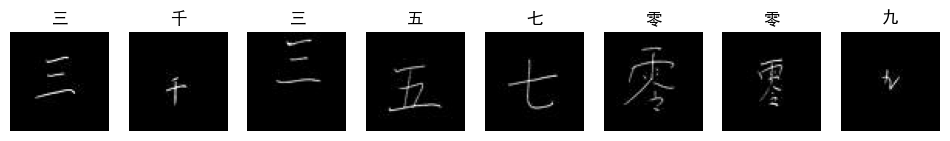

In [16]:
"""
show_images，可视化图像。
它接受图像列表 imgs、行数 num_rows、列数 num_cols、
可选的标题列表 titles 和缩放比例 scale。
函数通过 matplotlib 绘制图像，并设置坐标轴的可见性和标题。
"""

import matplotlib.pyplot as plt
#中文
from pylab import*
mpl.rcParams['font.sans-serif']=['SimHei']
import numpy as np

# 从训练集中随机选择几个样例
sample_idxs = np.random.choice(len(X_train), size=8, replace=False)

# 显示这些图像样例
hanzi = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十', '百', '千', '万', '亿']
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 3))

for i, idx in enumerate(sample_idxs):
    axes[i].imshow(np.squeeze(X_train[idx]), cmap='gray') #cmap='viridis'是彩色
    axes[i].set_title(hanzi[y_train[idx]])
    axes[i].axis('off')

plt.show()

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2 #正则
from tensorflow.keras.callbacks import EarlyStopping

# 将数据转换为 TensorFlow 张量 此处不能.shuffle(2000)因为会导致标签无法对应
X_train = tf.stack(X_train)
y_train = tf.constant(y_train)
X_test = tf.stack(X_test)
y_test = tf.constant(y_test)


# 转换标签为 one-hot 编码 因为y_train和y_test的形状是(None,)即1D张量 而输出层的形状是 (None, 15)即2D张量
y_train = to_categorical(y_train, num_classes=15)
y_test = to_categorical(y_test, num_classes=15)

"""
如果原始数据是按照某种顺序排列的(比如按时间顺序或其他特征顺序),
那么在转换为张量之前,对数据进行 shuffle 会更好。
这样可以打乱原有的顺序,防止模型在训练时过度拟合某些特定的模式。
"""
# #打乱顺序
# # 将特征和标签拼接为完整数据集
# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# # 对数据集进行随机打乱
# train_ds = train_ds.shuffle(buffer_size=int(15000*train_rate))
# test_ds=test_ds.shuffle(buffer_size=int(15000*(1-train_rate)))


# 对训练集与测试集进行batch_size 划分
"""
batch() 操作,将训练数据集转换成一个个小批量(batch)的形式,这样可以提高训练效率和内存利用率。
prefetch() 操作可以让 TensorFlow 在训练过程中异步地准备下一个批次的数据,减少数据加载对训练速度的影响。
"""
# train_ds = train_ds.batch(batch_size)
# train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_ds = test_ds.batch(batch_size)
# test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

"""
每个样本是一张 64x64 像素的灰度图像(最后一维表示通道数为 1)。
X_train shape: (10500, 64, 64, 1)
表示训练集有 10500 个标签,每个标签是一个整数值。
y_train shape: (10500,)
表示训练集的标签经过one-hot编码后,每个样本的标签变成了一个 15 维的向量。其中 15 代表类别数。
y_train_oh shape: (10500, 15)

X_test shape: (4500, 64, 64, 1)
y_test shape: (4500,)
y_test_oh shape: (4500, 15)
"""


# 构建模型
model = tf.keras.Sequential([
    #保持输出特征图大小与输入特征图大小相同。
    # 层数过低导致越训练精度下降无法拟合特征
    # 层数过高导致过拟合 loss飙升和test精度拟合卡在0.667  input_shape=(64, 64, 1)
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",input_shape=[64, 64, 1]),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(15, activation="softmax")
])

#超参数
epochs = 15
batch_size = 128
lr=0.003


# 编译模型
model.summary()
#     optimizer="adam",  optimizer=Adam(learning_rate=lr),
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 定义数据增强参数 包括随机旋转、平移、水平翻转等操作。这可以有效扩充训练数据,提高模型的泛化能力。
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True)

# model.fit(datagen.flow(X_train, y_train_oh, batch_size=batch_size),
#           epochs=epochs,
#           validation_data=(X_test, y_test_oh),
#           steps_per_epoch=len(X_train) // batch_size
#          )


# 定义早停回调函数     callbacks=[early_stopping]
early_stopping = EarlyStopping(
    monitor='val_loss',  # 监控的指标是验证集损失
    patience=5,  # 连续5个epoch验证集性能没有提升就停止训练
    verbose=1  # 输出早停信息
)

# 训练模型 model.fit() 函数会使用训练集 (X_train, y_train_oh) 来训练模型,
# 每个 epoch 会使用完整的训练集,并且每个 batch 包含 batch_size 个样本。
# 同时,它会使用验证集 (X_test, y_test_oh) 来评估模型在每个 epoch 结束后的性能。
model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test),
)
# model.fit(
#     train_ds,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_data=test_ds
# )


# 评估模型
loss, accuracy = model.evaluate(tf.data.Dataset.from_tensor_slices((X_test, y_test)))
# loss, accuracy = model.evaluate(test_ds)

print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121,999 (4.28 MB)

 Trainable params: 1,121,999 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - accuracy: 0.2154 - loss: 2.3750 - val_accuracy: 0.7020 - val_loss: 1.0697
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.6513 - loss: 1.0237 - val_accuracy: 0.8417 - val_loss: 0.5673
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.8091 - loss: 0.5529 - val_accuracy: 0.8953 - val_loss: 0.3545
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.8832 - loss: 0.3640 - val_accuracy: 0.9137 - val_loss: 0.2684
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.9130 - loss: 0.2735 - val_accuracy: 0.9307 - val_loss: 0.2328
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.9318 - loss: 0.2054 - val_accuracy: 0.9343 - val_loss: 0.2169
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - accuracy: 0.9484 - loss: 0.1708 - val_accuracy: 0.9377 - val_loss: 0.2003
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.9583 - loss: 0.1318 - val_accu

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None